In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
import spacy.cli
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

In [3]:
import pt_core_news_sm
spc_pt = pt_core_news_sm.load()

In [4]:
from olist.data import Olist
data = Olist().get_data()

In [5]:
# from olist.seller_updated import Seller
# sellers = Seller().get_training_data()

In [6]:
# from olist.product import Product
# products = Product().get_training_data()

In [7]:
reviews = data['order_reviews'].copy()

### 1. Data Cleaning

In [8]:
reviews.isnull().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       88285
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

#### Duplicates

In [9]:
# test for duplicates
dup = round(sum(reviews.duplicated("review_id")) / (len(data) * 100), 4)
print(f'{dup}%')

0.9189%


In [10]:
reviews[reviews.duplicated("review_id", keep=False)].sort_values(by ="review_id").head(5)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
47045,00130cbe1f9d422698c812ed8ded1919,dfcdfc43867d1c1381bfaf62d6b9c195,1,NaN,"O cartucho ""original HP"" 60XL não é reconhecid...",2018-03-07 00:00:00,2018-03-20 18:08:23
30062,00130cbe1f9d422698c812ed8ded1919,04a28263e085d399c97ae49e0b477efa,1,NaN,"O cartucho ""original HP"" 60XL não é reconhecid...",2018-03-07 00:00:00,2018-03-20 18:08:23
63695,0115633a9c298b6a98bcbe4eee75345f,0c9850b2c179c1ef60d2855e2751d1fa,5,NaN,NaN,2017-09-21 00:00:00,2017-09-26 03:27:47
91399,0115633a9c298b6a98bcbe4eee75345f,78a4201f58af3463bdab842eea4bc801,5,NaN,NaN,2017-09-21 00:00:00,2017-09-26 03:27:47
57727,0174caf0ee5964646040cd94e15ac95e,74db91e33b4e1fd865356c89a61abf1f,1,NaN,Produto entregue dentro de embalagem do fornec...,2018-03-07 00:00:00,2018-03-08 03:00:53


In [11]:
# remove duplicates
reviews.drop_duplicates("review_id", inplace=True)

In [12]:
# merge 'review_comment_title' e 'review_comment_message' and remove empty comments

In [13]:
# avoid issues when concatenating
reviews.fillna('', inplace = True)

In [14]:
# concat both columns
reviews['review'] = reviews['review_comment_title'] + ' ' + reviews['review_comment_message']

In [15]:
# remove empty comments
reviews = reviews[reviews['review'] != ' ']

In [16]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43152 entries, 3 to 99999
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                43152 non-null  object
 1   order_id                 43152 non-null  object
 2   review_score             43152 non-null  int64 
 3   review_comment_title     43152 non-null  object
 4   review_comment_message   43152 non-null  object
 5   review_creation_date     43152 non-null  object
 6   review_answer_timestamp  43152 non-null  object
 7   review                   43152 non-null  object
dtypes: int64(1), object(7)
memory usage: 3.0+ MB


### Review Scores

In [17]:
reviews['review_score'].value_counts().sort_index()

1     9153
2     2220
3     3721
4     6296
5    21762
Name: review_score, dtype: int64

In [18]:
# classifying reviews
labels = []
for score in reviews['review_score']:
    if score > 4:
        labels.append(1)
    else:
        labels.append(0)

reviews['label'] = labels

In [19]:
# importing stopwords for portuguese language
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/renatoboemer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
stopwords_pt = stopwords.words("portuguese")
stopwords_pt[:5] # sample

['de', 'a', 'o', 'que', 'e']

In [21]:
stopwords_pt.remove('não')
stopwords_pt.remove('nem')

In [22]:
def cleaning(comment):
    """"
    lowercase str, select letters, remove stopwords 
    lemmatise and returns a str 
    """
    comment = re.sub(r'[\W\d_]+', ' ', comment.lower())
    comment = [word for word in comment.split() if word not in stopwords_pt]
    spc_comment = spc_pt(" ".join(comment))
    tokens = [word.lemma_ if word.lemma_ != "-PRON-" else word.lower_ for word in spc_comment]
  
    return ' '.join(tokens)

In [23]:
reviews['review'] = reviews['review'].apply(cleaning)

In [24]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43152 entries, 3 to 99999
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                43152 non-null  object
 1   order_id                 43152 non-null  object
 2   review_score             43152 non-null  int64 
 3   review_comment_title     43152 non-null  object
 4   review_comment_message   43152 non-null  object
 5   review_creation_date     43152 non-null  object
 6   review_answer_timestamp  43152 non-null  object
 7   review                   43152 non-null  object
 8   label                    43152 non-null  int64 
dtypes: int64(2), object(7)
memory usage: 3.3+ MB


In [25]:
reviews = reviews[reviews['review'] != '']

### Bags

In [26]:
from sklearn.feature_extraction.text import CountVectorizer

In [27]:
# Instantiate the CountVectorizer, set binary=True
vectorizer = CountVectorizer(binary=True, max_features=5000)
text = reviews['review']

# Vectorise
X_bow = vectorizer.fit_transform(text)

In [28]:
X_bow.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [29]:
print(X_bow.shape, type(X_bow))

(42891, 5000) <class 'scipy.sparse.csr.csr_matrix'>


#### TF-IDF

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [31]:
# Instantiate TfidfVectorizer
tfidf_vect = TfidfVectorizer(max_features=5000)

# Vectorise
X_tfidf = tfidf_vect.fit_transform(text)

#### Models

In [32]:
from sklearn.model_selection import train_test_split

In [33]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X_bow, reviews['label'],
                                                        test_size=0.3, random_state = 10)

X2_train, X2_test, y2_train, y2_test = train_test_split(X_tfidf, reviews['label'],
                                                        test_size=0.3, random_state = 10)

In [34]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score

In [35]:
def metrics(y_true, y_pred):
    print("Accuracy: ", accuracy_score(y_true, y_pred))
    print("\nAUROC:", roc_auc_score(y_true, y_pred))
    print("\nF1-Score:", f1_score(y_true, y_pred, average='weighted'))
    print("\nMatriz de confusão:")
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True)
    plt.show()

### Logistic Regression

In [36]:
from sklearn.linear_model import LogisticRegression

In [37]:
reglog = LogisticRegression()
reglog.fit(X1_train, y1_train)

/Users/renatoboemer/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [38]:
y1_reglog_pred = reglog.predict(X1_test)

Accuracy:  0.8305097917314268

AUROC: 0.8300204561827561

F1-Score: 0.8296214688230983

Matriz de confusão:


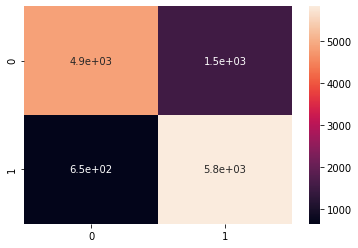

In [39]:
metrics(y1_test, y1_reglog_pred)

In [40]:
reglog2 = LogisticRegression()
reglog2.fit(X2_train, y2_train)
y2_reglog_pred = reglog2.predict(X2_test)

/Users/renatoboemer/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy:  0.8321417469692259

AUROC: 0.8317737035054389

F1-Score: 0.8316353604253662

Matriz de confusão:


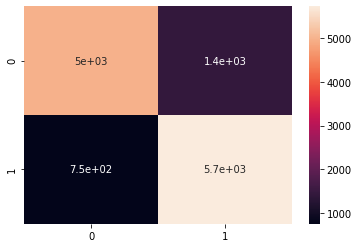

In [41]:
metrics(y2_test, y2_reglog_pred)

### Testing

In [42]:
def predicting(texto):
    texto_vetorizado = tfidf_vect.transform([texto])
    pred = reglog2.predict(texto_vetorizado)
    if pred == 0:
        print('Negative Review')
    else:
        print('Positive Review')

In [43]:
predicting('Esse produto é um lixo!') # negative

Negative Review


In [55]:
predicting('bom')   # positive --> not working!

Positive Review
